#  <span style="color:#cc416d">Análisis de los datos de GRACE </span>
###  <span style="color:#cc416d">2003-02-01 al 2022-12-31 </span>

In [29]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.ops import transform
import contextily as ctx
from shapely.geometry import LineString, box
from shapely.geometry import Polygon
from pyproj import Transformer
import contextily as ctx
import matplotlib.patheffects as pe

###  <span style="color:#cc416d">Ruta de trabajo </span>

In [3]:
path = "C:/Proyectos/2024/Conejos/mapas/GRACE"
os.chdir(path)
print ("Ruta de trabajo:   " + path)
print ("\U0001F40D")

Ruta de trabajo:   C:/Proyectos/2024/Conejos/mapas/GRACE
🐍


###  <span style="color:#cc416d">Lectura del CSV </span>

In [4]:
grace = pd.read_csv("GRACE_todos2022.csv")
print ("\U0001F40D")

🐍


###  <span style="color:#cc416d">Datos estádisticos </span>

In [5]:
grace

,time,lat,lon,GWS_tavg
0,2003-02-01,30.625,-107.375,358.04600
1,2003-02-01,30.625,-107.125,355.74588
2,2003-02-01,30.625,-106.875,502.02274
3,2003-02-01,30.625,-106.625,664.48830
4,2003-02-01,30.625,-106.375,773.22320
...,...,...,...,...
261859,2022-12-31,31.875,-107.125,235.48119
261860,2022-12-31,31.875,-106.875,293.02496
261861,2022-12-31,31.875,-106.625,569.29160
261862,2022-12-31,31.875,-106.375,567.23340


In [6]:
grace.describe()

,lat,lon,GWS_tavg
count,261864.000000,261864.000000,261864.000000
mean,31.250000,-106.750000,491.762046
std,0.426957,0.426957,119.215037
min,30.625000,-107.375000,231.838650
25%,30.875000,-107.125000,385.759288
50%,31.250000,-106.750000,491.789150
75%,31.625000,-106.375000,571.068138
max,31.875000,-106.125000,853.994800


In [7]:
grace["GWS_tavg"].describe()

count    261864.000000
mean        491.762046
std         119.215037
min         231.838650
25%         385.759288
50%         491.789150
75%         571.068138
max         853.994800
Name: GWS_tavg, dtype: float64

###  <span style="color:#cc416d">Histograma y boxplot</span>

[358.046   355.74588 502.02274 ... 569.2916  567.2334  491.6554 ]
0


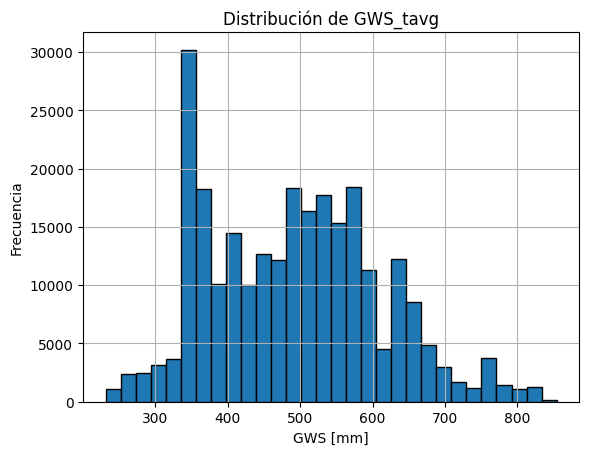

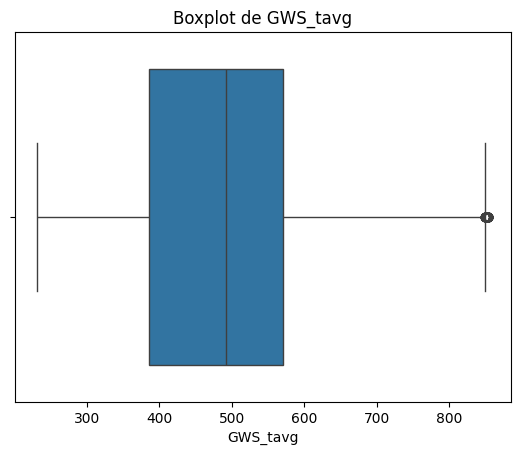

In [8]:
# 3. Valores únicos (útil si hay datos tipo 'NAN', -9999, etc.)
print(grace["GWS_tavg"].unique())

# 4. Ver si hay valores nulos
print(grace["GWS_tavg"].isnull().sum())

# 5. Histograma
plt.hist(grace["GWS_tavg"].dropna(), bins=30, edgecolor='black')
plt.title("Distribución de GWS_tavg")
plt.xlabel("GWS [mm]")
plt.ylabel("Frecuencia")
plt.grid(True)

# plt.savefig("estadisticaGRACE.png", dpi=300)

plt.show()

# 6. Boxplot para ver outliers
sns.boxplot(x=grace["GWS_tavg"])
plt.title("Boxplot de GWS_tavg")
plt.show()


#  <span style="color:#cc416d">Verificar como está elórden de las coordenadas </span>

Fecha seleccionada: 2005-03-21  |  máximo GWS: 853.99 mm
CSV de verificación guardado: grid_debug_fecha_sel.csv
Esquinas (lon,lat):
  SW: (np.float64(-107.5), np.float64(30.5))
  NW: (np.float64(-107.5), np.float64(32.0))
  SE: (np.float64(-106.0), np.float64(30.5))
  NE: (np.float64(-106.0), np.float64(32.0))


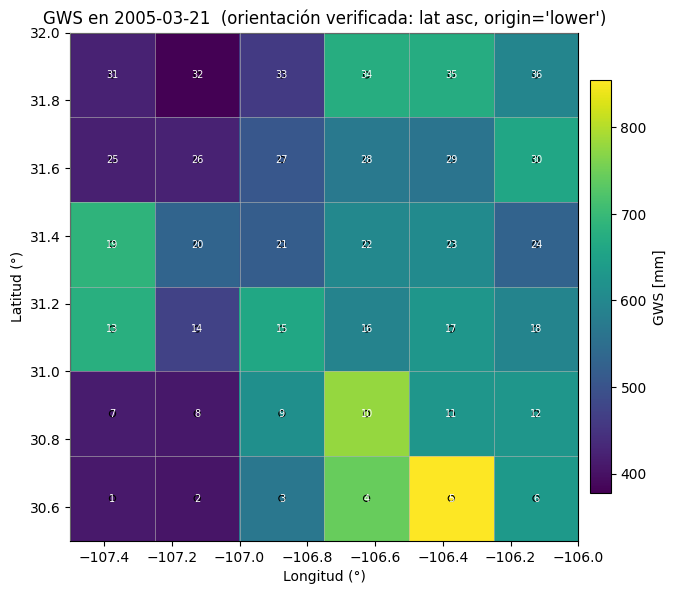

In [5]:
if not np.issubdtype(grace['time'].dtype, np.datetime64):
    grace['time'] = pd.to_datetime(grace['time'])

# 1) Grilla MAESTRA (centros), con redondeo para evitar ruido
lon_centers = np.sort(np.round(grace['lon'].unique(), 6))        # asc
lat_centers = np.sort(np.round(grace['lat'].unique(), 6))        # asc  <<--- ojo: ascendente
nx, ny = len(lon_centers), len(lat_centers)
assert nx*ny == 36, f"Se esperaban 36 celdas; nx={nx}, ny={ny}"

lon_to_i = {lon:i for i, lon in enumerate(lon_centers)}          # i = columna
lat_to_j = {lat:j for j, lat in enumerate(lat_centers)}          # j = fila (lat asc)

# 2) Edges a partir de centros
def edges_from_centers(c):
    c = np.asarray(c, float)
    mids = (c[:-1] + c[1:]) / 2
    first_edge = c[0] - (mids[0] - c[0])
    last_edge  = c[-1] + (c[-1] - mids[-1])
    return np.concatenate(([first_edge], mids, [last_edge]))

lon_edges = edges_from_centers(lon_centers)   # asc
lat_edges = edges_from_centers(lat_centers)   # asc

# 3) Máximo global (para el ejemplo; usa la fecha que quieras cotejar)
idx_max   = grace['GWS_tavg'].idxmax()
row_max   = grace.loc[idx_max]
fecha_sel = pd.to_datetime(row_max['time'])
print(f"Fecha seleccionada: {fecha_sel.date()}  |  máximo GWS: {row_max['GWS_tavg']:.2f} mm")

g_d = grace[grace['time'] == fecha_sel].copy()
g_d['lon_r'] = np.round(g_d['lon'], 6)
g_d['lat_r'] = np.round(g_d['lat'], 6)
assert len(g_d) == 36, f"En {fecha_sel.date()} hay {len(g_d)} puntos, no 36."

# 4) Construir GRID (ny x nx) y tabla de depuración
grid = np.full((ny, nx), np.nan, float)
rows = []
for _, r in g_d.iterrows():
    if r['lon_r'] in lon_to_i and r['lat_r'] in lat_to_j:
        i = lon_to_i[r['lon_r']]
        j = lat_to_j[r['lat_r']]
        grid[j, i] = r['GWS_tavg']
        cell_id = j*nx + i + 1  # con lat asc + origin='lower'
        rows.append({"cell_id": cell_id, "lon": r['lon_r'], "lat": r['lat_r'], "i": i, "j": j, "GWS": r['GWS_tavg']})
    else:
        print("⚠️ Punto fuera de grilla maestra:", r['lon_r'], r['lat_r'])

debug_df = pd.DataFrame(rows).sort_values(["j","i"]).reset_index(drop=True)
debug_df.to_csv("grid_debug_fecha_sel.csv", index=False)
print("CSV de verificación guardado: grid_debug_fecha_sel.csv")
print("Esquinas (lon,lat):")
print("  SW:", (lon_edges[0],  lat_edges[0]))
print("  NW:", (lon_edges[0],  lat_edges[-1]))
print("  SE:", (lon_edges[-1], lat_edges[0]))
print("  NE:", (lon_edges[-1], lat_edges[-1]))

# 5) Plot con orientación natural (lat asc, origin='lower')
fig, ax = plt.subplots(figsize=(7.6, 6.6))
im = ax.imshow(
    grid, origin='lower', cmap='viridis',  # <<--- origin='lower' porque lat es ascendente
    extent=[lon_edges[0], lon_edges[-1],   # xmin, xmax
            lat_edges[0], lat_edges[-1]]   # ymin=sur, ymax=norte
)

# Rejilla en bordes
for x in lon_edges:
    ax.plot([x, x], [lat_edges[0], lat_edges[-1]], color='0.7', linewidth=0.6, alpha=0.7, zorder=10)
for y in lat_edges:
    ax.plot([lon_edges[0], lon_edges[-1]], [y, y], color='0.7', linewidth=0.6, alpha=0.7, zorder=10)

# 6) Superponer los 36 puntos reales de ese día (cotejo visual)
ax.scatter(g_d['lon_r'], g_d['lat_r'], s=20, edgecolor='k', facecolor='none', linewidth=0.8, zorder=20)
# opcional: numerar cell_id en el centro de cada celda:
lon_cent = (lon_edges[:-1] + lon_edges[1:]) / 2
lat_cent = (lat_edges[:-1] + lat_edges[1:]) / 2
cid = 1
for jj, y in enumerate(lat_cent):
    for ii, x in enumerate(lon_cent):
        ax.text(x, y, str(cid), ha='center', va='center', fontsize=7, color='white', zorder=30)
        cid += 1

ax.set_title(f"GWS en {fecha_sel.date()}  (orientación verificada: lat asc, origin='lower')")
ax.set_xlabel("Longitud (°)")
ax.set_ylabel("Latitud (°)")
ax.set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.02); cbar.set_label("GWS [mm]")

# plt.tight_layout()
# plt.savefig("gws_map_verificado_fecha.png", dpi=300)
plt.show()

In [14]:
# Centros lon/lat (lons asc, lats desc)
lons = np.sort(g_d['lon'].unique())
lats = np.sort(g_d['lat'].unique())[::-1]   # descendente (norte→sur)
nx, ny = len(lons), len(lats)
assert nx * ny == 36, "La rejilla no parece 6×6"

In [15]:
lons = np.asarray(sorted(lons))            # asc
lats = np.asarray(sorted(lats, reverse=True))  # desc (norte→sur)
nx, ny = len(lons), len(lats)

##  <span style="color:#cc416d">Orden de los cuadros, pixeles con AOL </span>

In [12]:
t0 = grace["time"].min()

# Validación mínima
assert {"lat","lon","GWS_tavg"}.issubset(g0.columns), "Faltan columnas lat/lon/GWS_tavg"

# ---------------------------------------------------------------------
# 2) Crear índices X,Y y cell_id (orden raster: lon asc, lat desc)
# ---------------------------------------------------------------------
# Norte arriba: latitudes descendentes; longitudes ascendentes
lats = sorted(g0["lat"].dropna().unique(), reverse=True)   # desc
lons = sorted(g0["lon"].dropna().unique())                 # asc
nx, ny = len(lons), len(lats)
assert nx*ny == len(g0), f"Se esperaban {nx*ny} celdas; hay {len(g0)} filas para {t0.date()}"

lon_to_x = {lon: i for i, lon in enumerate(lons)}
lat_to_y = {lat: j for j, lat in enumerate(lats)}

g0["X"] = g0["lon"].map(lon_to_x)
g0["Y"] = g0["lat"].map(lat_to_y)
g0["cell_id"] = g0["Y"] * nx + g0["X"] + 1  # IDs 1..36


NameError: name 'g0' is not defined

##  <span style="color:#cc416d">Funciones</span>

In [10]:
def lon_to_xc(lon):
    # Interpola lon reales -> centros de índice en X
    return np.interp(lon, lons, x_centers)

def lat_to_yc(lat):
    # Y crece hacia el sur, por eso invertimos
    return np.interp(lat, lats_asc, y_centers[::-1])

def geom_lonlat_to_index(geom):# Transforma cualquier geometría (lon,lat) a (x_idx, y_idx)
    
    return transform(lambda x, y, z=None: (lon_to_xc(x), lat_to_yc(y)), geom)

####  <span style="color:#cc416d">Centros de índice (a mitad de cada celda)</span>

In [21]:
x_centers = np.arange(nx) + 0.5                 # 0.5 .. nx-0.5
y_centers = np.arange(ny) + 0.5                 # 0.5 .. ny-0.5

# Para interpolación en lat: necesitamos ascendente
lats_asc = np.array(sorted(lats))               # ascendente

####  <span style="color:#cc416d">Cargar límite y pasarlo a lon/lat (EPSG:4326)</span>

In [23]:
gdf_limite = gpd.read_file("C:/Proyectos/2024/Conejos/mapas/aol_conejos.shp")
gdf_limite_4326 = gdf_limite.to_crs(4326)

gdf_limite_idx = gdf_limite_4326.copy()
gdf_limite_idx["geometry"] = gdf_limite_idx.geometry.apply(geom_lonlat_to_index)

# (Debug) Imprime extensión del límite en coordenadas de índice
print("Bounds índice del límite:", gdf_limite_idx.total_bounds)  # [minx, miny, maxx, maxy]

Bounds índice del límite: [0.79648204 0.85872728 4.18520947 4.79916612]


##  <span style="color:#cc416d">Orden de los cuadros, pixeles con AOL y cuadricula </span>

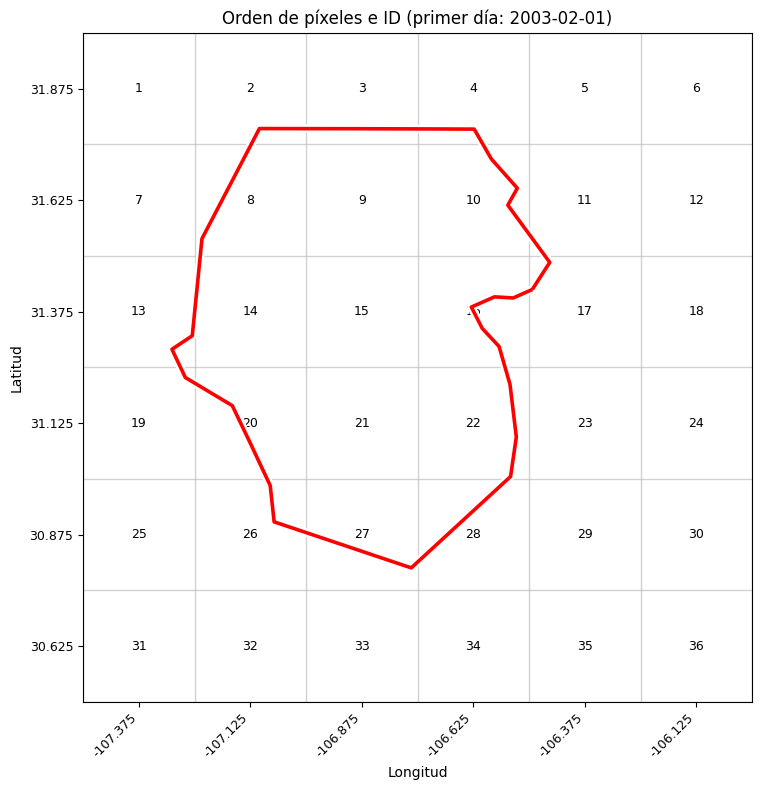

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))

# Líneas de grilla (gris claro)
for x in range(nx + 1):
    ax.plot([x, x], [0, ny], linewidth=1, color='0.7', alpha=0.6, zorder=1)
for y in range(ny + 1):
    ax.plot([0, nx], [y, y], linewidth=1, color='0.7', alpha=0.6, zorder=1)

# 5.2 IDs al centro de cada celda
for _, row in g0.iterrows():
    x, y = int(row["X"]), int(row["Y"])
    ax.text(x + 0.5, y + 0.5, f"{int(row['cell_id'])}",
            ha="center", va="center", fontsize=9, color="black", zorder=5)

# 5.3 Límite con halo (blanco grueso + rojo fino) por encima de todo
gdf_limite_idx.boundary.plot(ax=ax, color='white', linewidth=6, zorder=30)
gdf_limite_idx.boundary.plot(ax=ax, color='red',   linewidth=2.6, zorder=31)

# 5.4 Ejes en espacio de índices con etiquetas lon/lat
ax.set_xlim(0, nx)
ax.set_ylim(ny, 0)          # norte arriba
ax.set_aspect("equal")

ax.set_xticks(np.arange(nx) + 0.5)
ax.set_yticks(np.arange(ny) + 0.5)
ax.set_xticklabels([f"{lon:.3f}" for lon in lons], rotation=45, ha="right", fontsize=9)
ax.set_yticklabels([f"{lat:.3f}" for lat in lats], fontsize=9)

ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_title(f"Orden de píxeles e ID (primer día: {t0.date()})")
plt.tight_layout()
plt.show()


In [28]:
# Proyectar a 3857 para basemap
gdf_cells = gdf_cells.merge(stats_df, on='cell_id', how='left')
gdf_cells_3857  = gdf_cells.to_crs(3857)
gdf_limite_3857 = gdf_limite.to_crs(3857)

NameError: name 'gdf_cells' is not defined

In [26]:
xmin, ymin, xmax, ymax = gdf_limite_3857.total_bounds

NameError: name 'gdf_limite_3857' is not defined

##  <span style="color:#cc416d">AOL & cuadricula & Mapa base </span>

In [52]:
to_3857 = Transformer.from_crs(4326, 3857, always_xy=True)
# 1) Bordes (edges) a partir de tus centros lons/lats
def edges_from_centers(c):
    c = np.asarray(c, float)
    mids = (c[:-1] + c[1:]) / 2
    first_edge = c[0] - (mids[0] - c[0])
    last_edge  = c[-1] + (c[-1] - mids[-1])
    return np.concatenate(([first_edge], mids, [last_edge]))

lon_edges = edges_from_centers(lons)              # lons asc
lat_edges = edges_from_centers(lats[::-1])[::-1]  # lats desc → respeta orden

In [53]:
# 2) Proyecta edges a 3857 (x depende de lon; y de lat)
to_3857 = Transformer.from_crs(4326, 3857, always_xy=True)
x_edges_m, _ = to_3857.transform(lon_edges, [lat_edges[-1]]*len(lon_edges))
_, y_edges_m = to_3857.transform([lon_edges[0]]*len(lat_edges), lat_edges)

xmin, xmax = float(x_edges_m.min()), float(x_edges_m.max())
ymin, ymax = float(y_edges_m.min()), float(y_edges_m.max())

In [25]:
# (opcional) un pequeño margen en metros
padx = (xmax - xmin) * 0.01
pady = (ymax - ymin) * 0.01
xmin_p, xmax_p = xmin - padx, xmax + padx
ymin_p, ymax_p = ymin - pady, ymax + pady

NameError: name 'xmax' is not defined

NameError: name 'xmin_p' is not defined

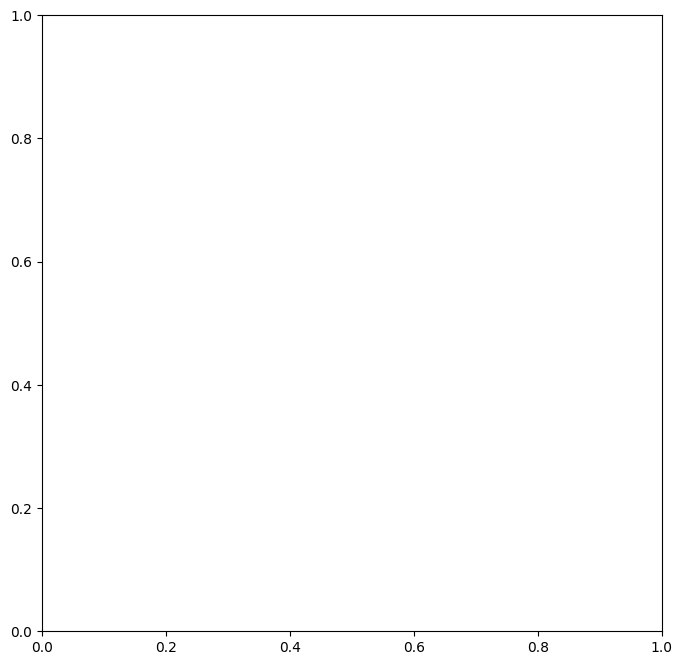

In [16]:
fig, ax = plt.subplots(figsize=(8,8))

# 3) Fija extent por BORDES de la grilla
ax.set_xlim(xmin_p, xmax_p)
ax.set_ylim(ymin_p, ymax_p)

# 4) Basemap (y volver a fijar extent por si lo movió)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)
ax.set_xlim(xmin_p, xmax_p)
ax.set_ylim(ymin_p, ymax_p)

# 5) Dibuja cuadrícula usando esos edges
for xm in x_edges_m:
    ax.plot([xm, xm], [ymin, ymax], linewidth=1, color='0.7', alpha=0.6, zorder=22)
for ym in y_edges_m:
    ax.plot([xmin, xmax], [ym, ym], linewidth=1, color='0.7', alpha=0.6, zorder=22)

# 6) Límite del acuífero en 3857
gdf_limite_3857 = gdf_limite.to_crs(3857)
gdf_limite_3857.boundary.plot(ax=ax, color='white', linewidth=6, zorder=30)
gdf_limite_3857.boundary.plot(ax=ax, color='red',   linewidth=2.6, zorder=31)

# 7) Etiquetas en centros (lat ascendente, lon ascendente)
cx_m, cy_m = to_3857.transform(
    np.tile(lons, len(lats)),           # repetir longitudes para cada latitud
    np.repeat(lats, len(lons))          # repetir cada latitud para todas las longitudes
)

# Generar IDs en el mismo orden que origin='lower'
for cid, (xm, ym) in enumerate(zip(cx_m, cy_m), start=1):
    ax.text(xm, ym, f"{cid}", ha="center", va="center",
            fontsize=9, color="black", zorder=32)

# 8) Ticks (si quieres que caigan en bordes, usa lon_edges/lat_edges)
step = max(1, len(lon_edges)//6)  # cada N bordes
lon_ticks_deg = lon_edges[::step]
lat_ticks_deg = lat_edges[::step]
lon_ticks_m, _ = to_3857.transform(lon_ticks_deg, [lat_edges[-1]]*len(lon_ticks_deg))
_, lat_ticks_m = to_3857.transform([lon_edges[0]]*len(lat_ticks_deg), lat_ticks_deg)
ax.set_xticks(lon_ticks_m); ax.set_yticks(lat_ticks_m)
ax.set_xticklabels([f"{x:.3f}°" for x in lon_ticks_deg], rotation=45, ha="right", fontsize=9)
ax.set_yticklabels([f"{y:.3f}°" for y in lat_ticks_deg], fontsize=9)

ax.set_xlabel("Longitud"); ax.set_ylabel("Latitud")
ax.set_title(f"Orden de píxeles e ID (primer día: {t0.date()})", pad=10)

# ruta_salida = os.path.join(carpeta_salida, f"interpolacioPiez.png")
plt.savefig("Mapa_Base_GRACE.png", dpi=300)

plt.tight_layout(); plt.show()
